## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%pylab inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal\calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

Populating the interactive namespace from numpy and matplotlib


## And so on and so forth...

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #undist = np.copy(img)  # Delete this line
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


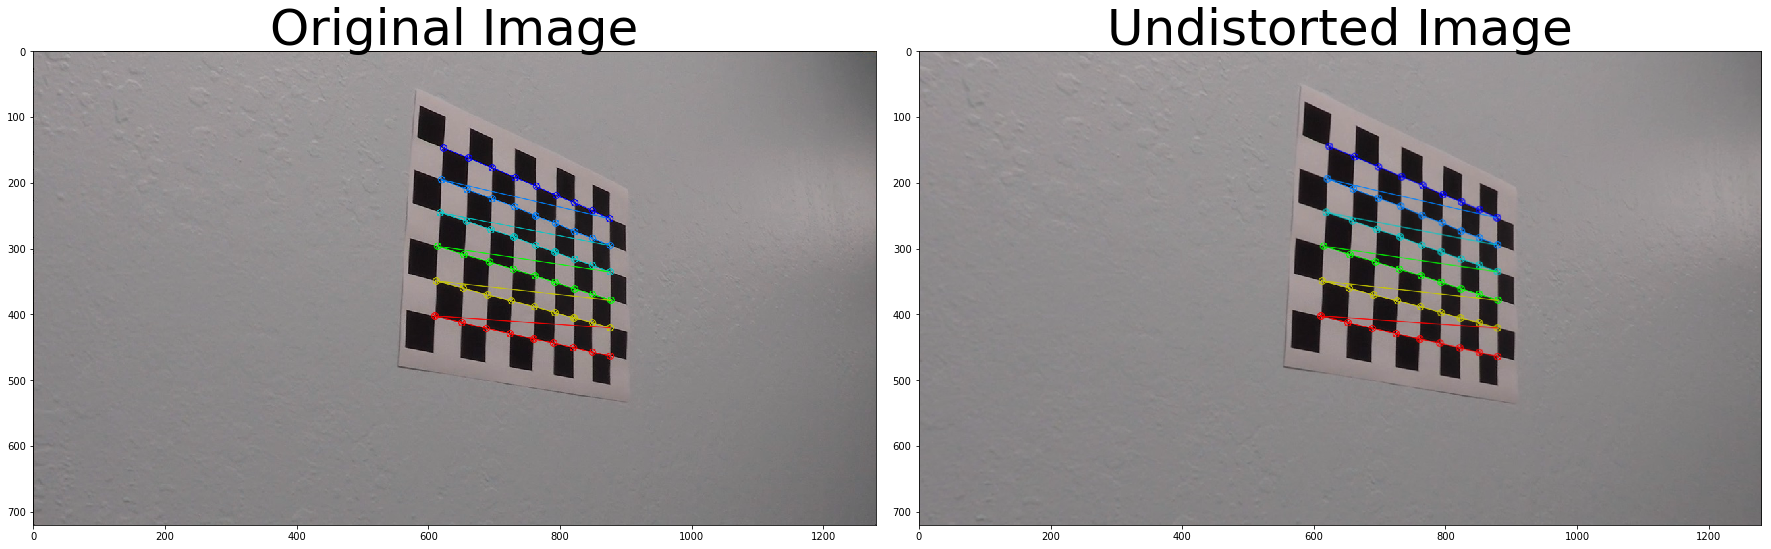

In [3]:
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

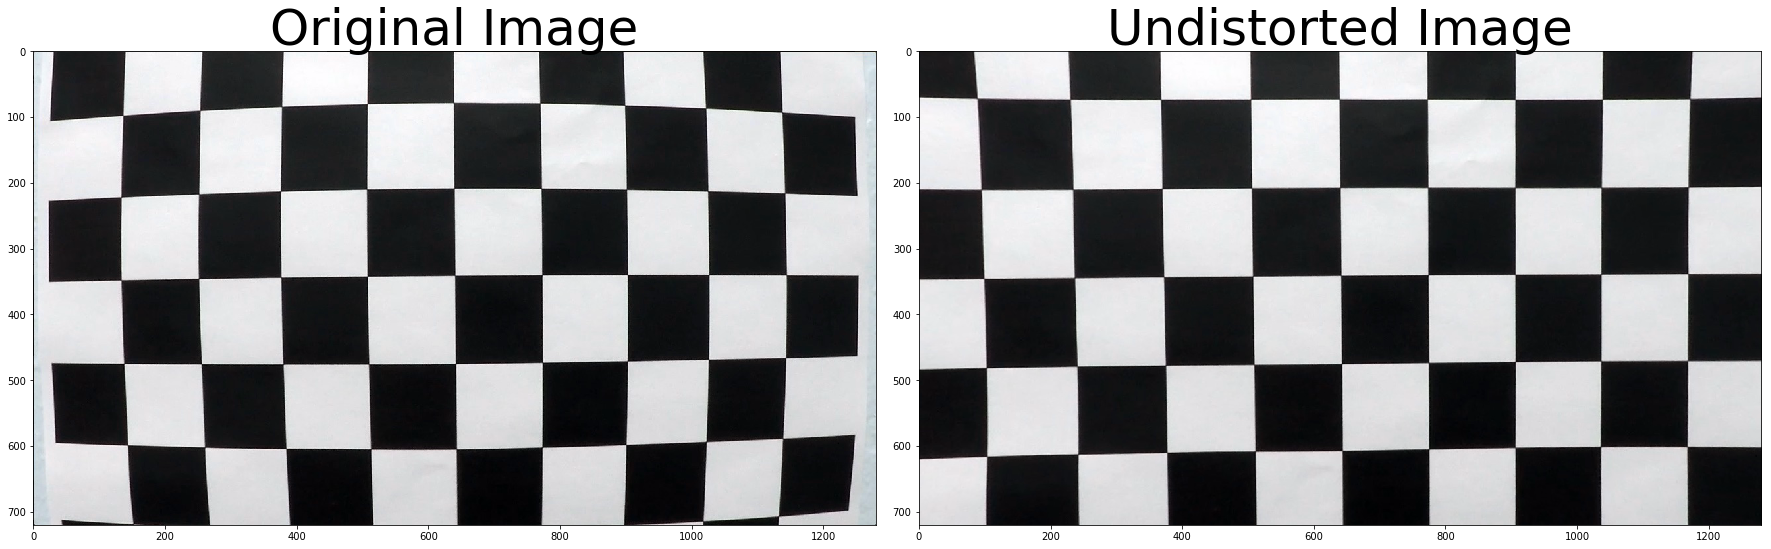

In [4]:
testimg = cv2.imread('camera_cal/calibration1.jpg')
undistorted = cal_undistort(testimg, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testimg)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Functions
These are the functions to detect the line and define the functions

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(img, cv2.CV_64F, int(orient=='x'), int(orient=='y'))
    # 2) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 3) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4) Create a mask of 1's where the scaled gradient magnitude
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    return grad_binary
 
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 2) Calculate the magnitude
    abs_sobel = (sobelx**2 + sobely**2)**0.5
    # 3) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 4) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 5) Return this mask as your binary_output image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Apply the following steps to img
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 2) Take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_mag = np.arctan2(abs_sobely, abs_sobelx)
    # 4) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(dir_mag)
    dir_binary[(dir_mag >= thresh[0]) & (dir_mag <= thresh[1])] = 1 
    # 5) Return this mask as your binary_output image
    return dir_binary

def b_threshold(image, thresh=(155,200)):
    b_channel = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= thresh[0]) & (b_channel <= thresh[1])] = 1
    return b_binary
    

def color_threshold(image, thresh=(170,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

def warpSettings(img):
    #offset = 300
    img_size = (img.shape[1], img.shape[0])
    #src = np.float32([[595,450],[685,450],[1038,675],[270,675]])
    src = np.float32([[574,466],[710,466],[1069,701],[232,701]])
    offsetx = 350
    offsety = 0
    dst_pt = np.float32([[offsetx, offsety], [img_size[0]-offsetx, offsety],[img_size[0]-offsetx, img_size[1]-offsety], [offsetx, img_size[1]-offsety]])
    M = cv2.getPerspectiveTransform(src, dst_pt)
    Minv = cv2.getPerspectiveTransform(dst_pt,src)
    return M, Minv, img_size

#this function is seperated to calculate M only once
def unwarp(img, M, img_size):
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def testUnwarp(img):
    M, Minv, img_size = warpSettings(img)
    warped = unwarp(img, M, img_size)
    return warped

def test_images(image, modified_image, title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(modified_image)
    ax2.set_title(title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

def plotAllSteps(originalImg, gradx, grady, mag_binary, dir_binary, s_binary, combined, unwarped_combined):
    test_images(originalImg, gradx, 'Gradient X')
    test_images(originalImg, grady, 'Gradient Y')
    test_images(originalImg, mag_binary, 'Gradient Magnituted')
    test_images(originalImg, dir_binary, 'Gradient Direction')
    test_images(originalImg, s_binary, 'Color Saturation')
    test_images(originalImg, combined, 'Combination of all')
    test_images(testUnwarp(originalImg), unwarped_combined, 'Unwarp the result')
    
def curvatureCalc(ploty, leftx, rightx, lefty, righty):
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ## check these values
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ym_per_pix = 3/116 #my value
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad
    
def lineFinder(binary_warped, debug = False):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    if debug:
        #plt.plot(histogram)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if debug:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 10)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 10) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    leftLane.allx = leftx
    leftLane.ally = lefty
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    rightLane.allx = rightx
    rightLane.ally = righty
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_curverad, right_curverad = curvatureCalc(ploty, leftx, rightx, lefty, righty)
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    distInMeters0, distValid0 = calculatePos(1280/2, left_fitx[-1], right_fitx[-1])
    distInMeters1, distValid1 = calculatePos(1280/2, left_fitx[0], right_fitx[0])
    distInMeters2, distValid2 = calculatePos(1280/2, left_fitx[100], right_fitx[100])
    if (distValid0 and distValid1 and distValid2):
        leftLane.line_base_pos = (distInMeters0 + distInMeters1 + distInMeters2)/3
        rightLane.line_base_pos = (distInMeters0 + distInMeters1 + distInMeters2)/3
        leftLane.detected = True
        leftLane.current_fit = left_fit
        leftLane.radius_of_curvature = left_curverad
        last3 = leftLane.recent_xfitted[-3:]
        last3.append(left_fitx)
        leftLane.recent_xfitted = last3[-3:]
        #leftLane.allx = left_fitx
        #leftLane.ally = ploty
        rightLane.detected = True
        rightLane.current_fit = right_fit
        rightLane.radius_of_curvature = right_curverad
        last3 = rightLane.recent_xfitted[-3:]
        last3.append(right_fitx)
        rightLane.recent_xfitted = last3[-3:]
        #rightLane.allx = right_fitx
        #rightLane.ally = ploty
    

    
    if debug:
        ###Visualization
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
    #Put the results in lane classes

        
    return left_fit, right_fit, left_curverad, right_curverad, ploty
        
def lineTracker(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #check if lanes are fine
    #add them to the last three
    left_curverad, right_curverad = curvatureCalc(ploty, leftx, rightx, lefty, righty)
    distInMeters0, distValid0 = calculatePos(1280/2, left_fitx[-1], right_fitx[-1])
    distInMeters1, distValid1 = calculatePos(1280/2, left_fitx[0], right_fitx[0])
    distInMeters2, distValid2 = calculatePos(1280/2, left_fitx[100], right_fitx[100])
    
    if (distValid0 and distValid1 and distValid2):
        leftLane.line_base_pos = (distInMeters0 + distInMeters1 + distInMeters2)/3
        rightLane.line_base_pos = (distInMeters0 + distInMeters1 + distInMeters2)/3

        leftLane.current_fit = left_fit
        last3 = leftLane.recent_xfitted[-3:]
        last3.append(left_fitx)
        leftLane.recent_xfitted = last3[-3:]
        leftLane.radius_of_curvature = left_curverad
        leftLane.allx = left_fitx
        leftLane.ally = ploty
        
        rightLane.current_fit = right_fit
        last3 = rightLane.recent_xfitted[-3:]
        last3.append(right_fitx)
        rightLane.recent_xfitted = last3[-3:]
        rightLane.radius_of_curvature = right_curverad
        rightLane.allx = right_fitx
        rightLane.ally = ploty
    else:
        leftLane.detected = False
        rightLane.detected = False
        
        
    return left_fit, right_fit, left_curverad, right_curverad, ploty

    
def pipeline(image, params, debug = False):
    dst_image = cal_undistort(image, objpoints, imgpoints)
    M, Minv, img_size = params
    
    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements
    dst_gray = cv2.cvtColor(dst_image, cv2.COLOR_BGR2GRAY)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #dst_gray = clahe.apply(dst_gray)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(dst_gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(dst_gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(dst_gray, sobel_kernel=ksize, mag_thresh=(50, 200))
    dir_binary = dir_threshold(dst_gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
    s_binary = color_threshold(dst_image, thresh=(170,255))
    b_binary = b_threshold(dst_image)

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1 ) | (b_binary == 1)] = 255
    unwarped_combined = unwarp(combined, M, img_size)
    if debug:
        plotAllSteps(dst_image, gradx, grady, mag_binary, dir_binary, s_binary, combined, unwarped_combined)
        cv2.imwrite('test_images/undistorted_.png',dst_image)
        cv2.imwrite('test_images/unwarped_.png',testUnwarp(dst_image))
    #unwarped_combined[unwarped_combined == 255] = 1
    #combTestimg_gray = cv2.cvtColor(unwarped_combined, cv2.COLOR_BGR2GRAY)
    binary_unwarped = cv2.threshold(unwarped_combined.astype(np.uint8), 127, 255, cv2.THRESH_BINARY)[1]
    return binary_unwarped



In [6]:
def showResult(originalImg, left_fit, right_fit, ploty, Minv):
    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    colorWarp = np.zeros_like(originalImg).astype(np.uint8)
    
    # Generate x and y values for plotting
    left_fitx = np.mean(leftLane.recent_xfitted,0)
    right_fitx = np.mean(rightLane.recent_xfitted,0)
    #draw the results if there is a lane, otherwise skip drawing to prevent crash
    if (left_fitx is None or any(isnan(left_fitx))):
        return originalImg
    else:
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(colorWarp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(colorWarp, Minv, (originalImg.shape[1], originalImg.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(originalImg, 1, newwarp, 0.3, 0)
        #plt.imshow(result)
        font = cv2.FONT_HERSHEY_SIMPLEX
        if (rightLane.line_base_pos>0):
            cv2.putText(result,'Vehicle is {:.2f}m right'.format(abs(rightLane.line_base_pos)),(10,160), font, 1,(0,255,0),2,cv2.LINE_AA)
        else:
            cv2.putText(result,'Vehicle is {:.2f}m left'.format(abs(rightLane.line_base_pos)),(10,160), font, 1,(0,255,0),2,cv2.LINE_AA)
        cv2.putText(result,'Curvature is {:.2f}m'.format(abs(rightLane.radius_of_curvature+leftLane.radius_of_curvature)/2),(10,200), font, 1,(0,255,0),2,cv2.LINE_AA)

    return result

def calculatePos(midpoint, linepolLeft, linepolRight):
    xm_per_pix = 3.7/582 #my value
    leftDist = midpoint - linepolLeft
    rightDist = linepolRight - midpoint
    #distance is normal?
    distanceNormal = False
    if(abs((leftDist+rightDist)-582)<100):
        distanceNormal = True
    #minus means vehicle is closer to the left line
    distInMeters = (leftDist - rightDist)*xm_per_pix
    return distInMeters, distanceNormal

    

Initialize parameters & test functions

In [7]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

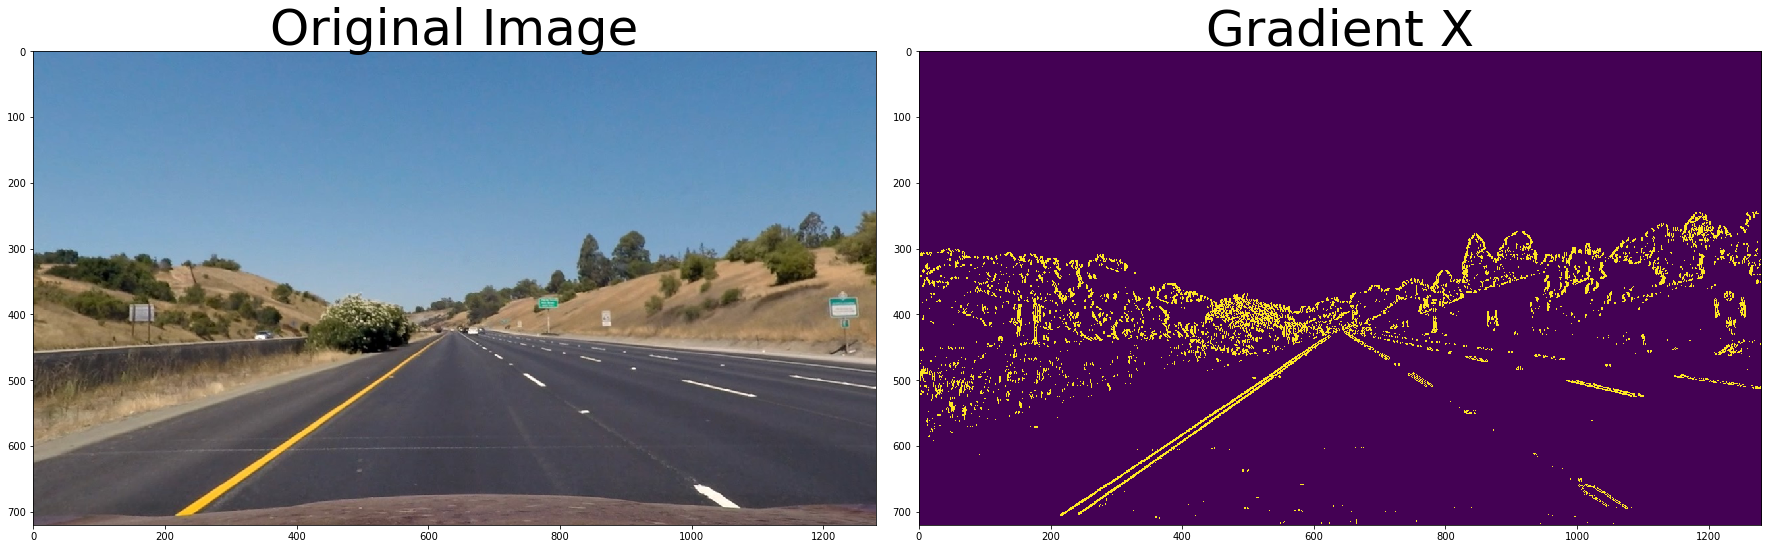

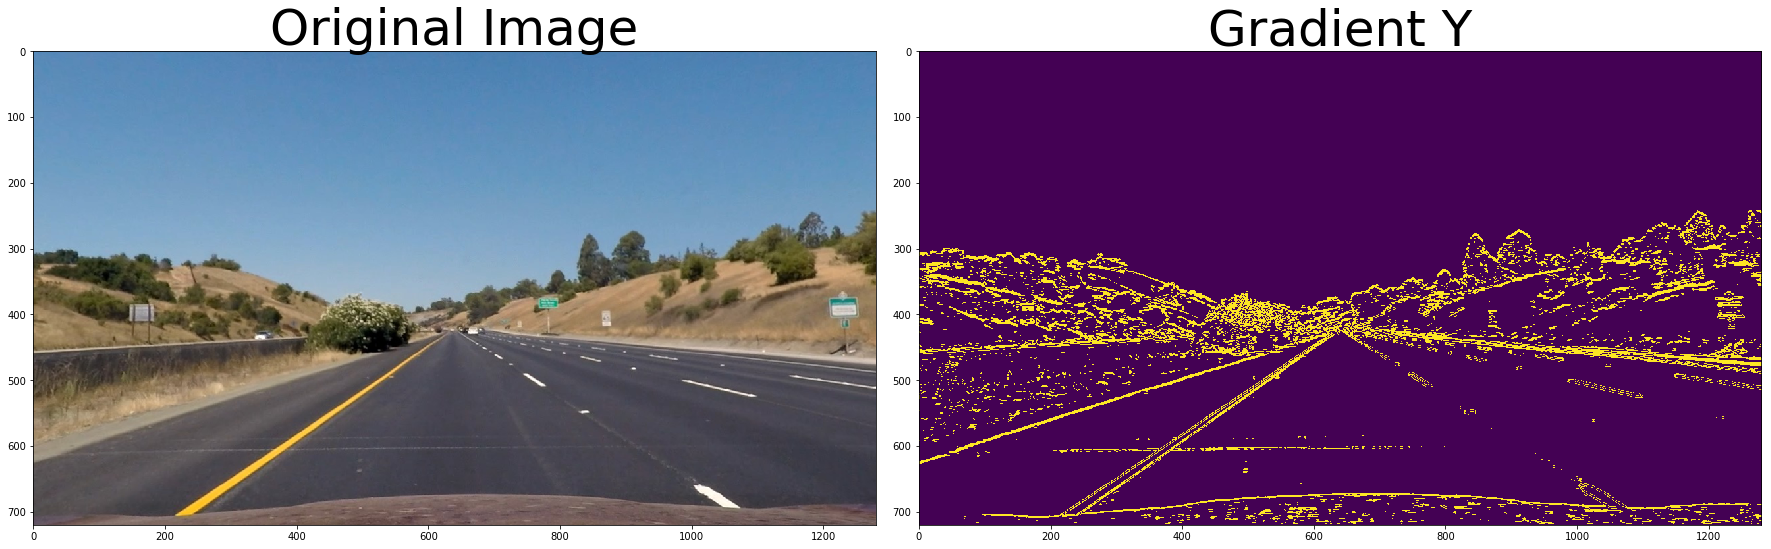

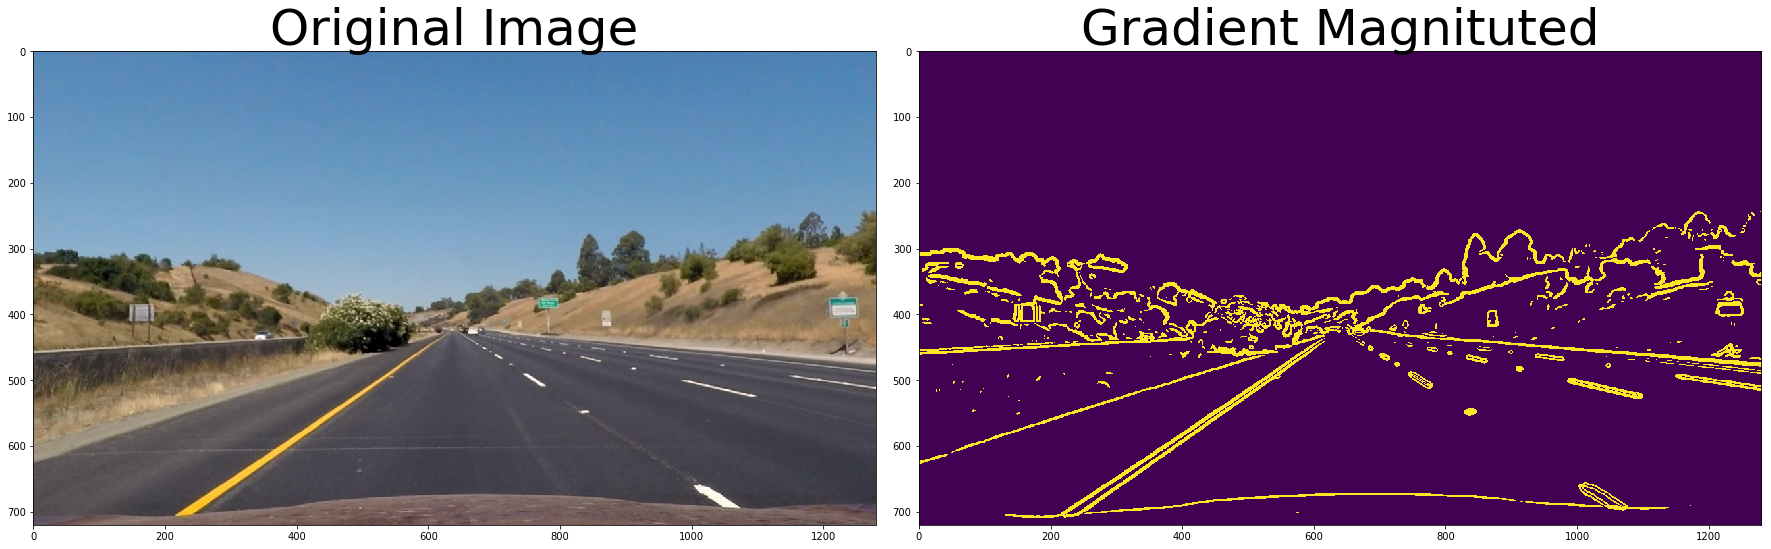

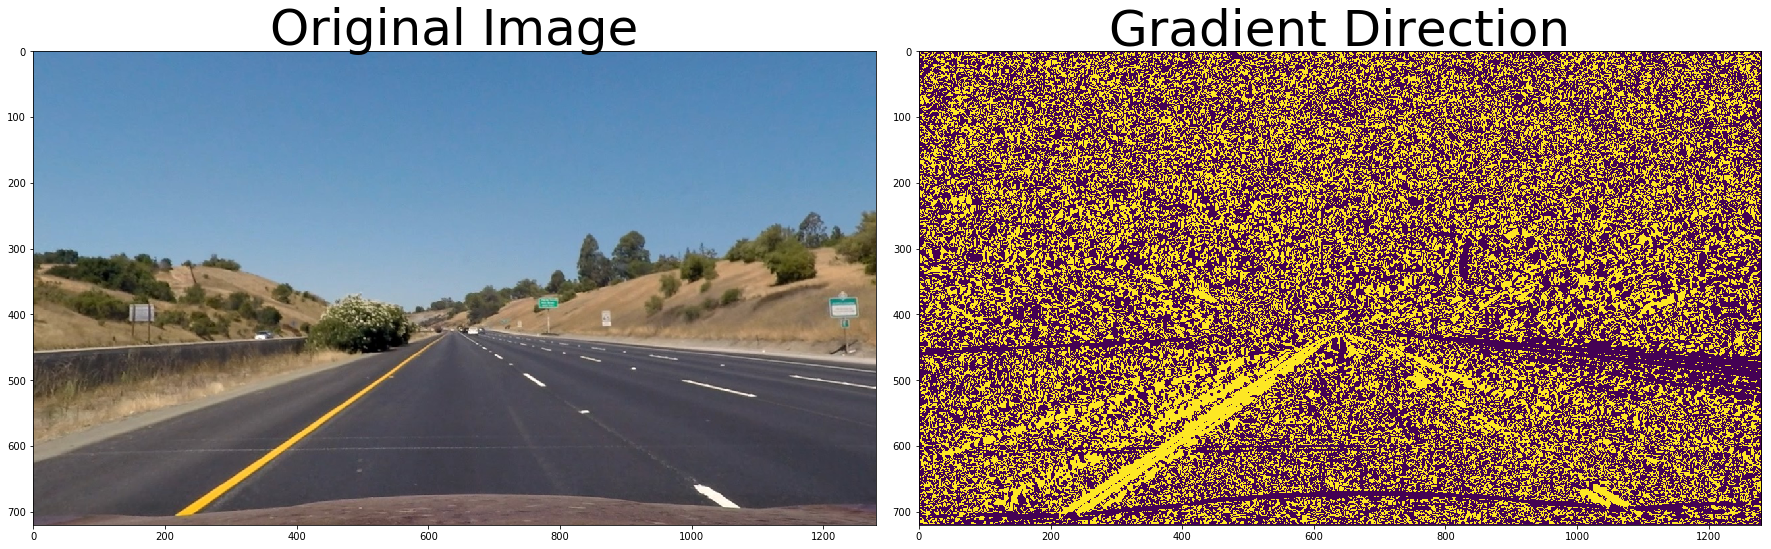

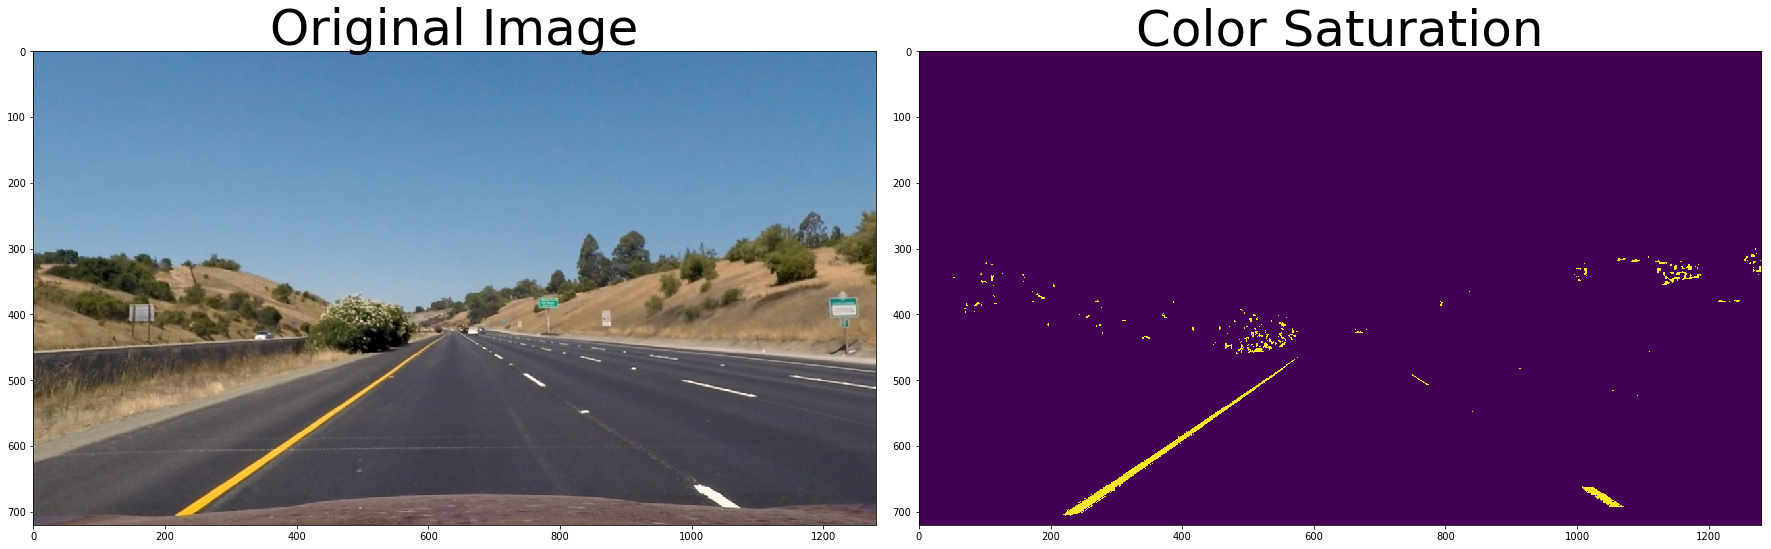

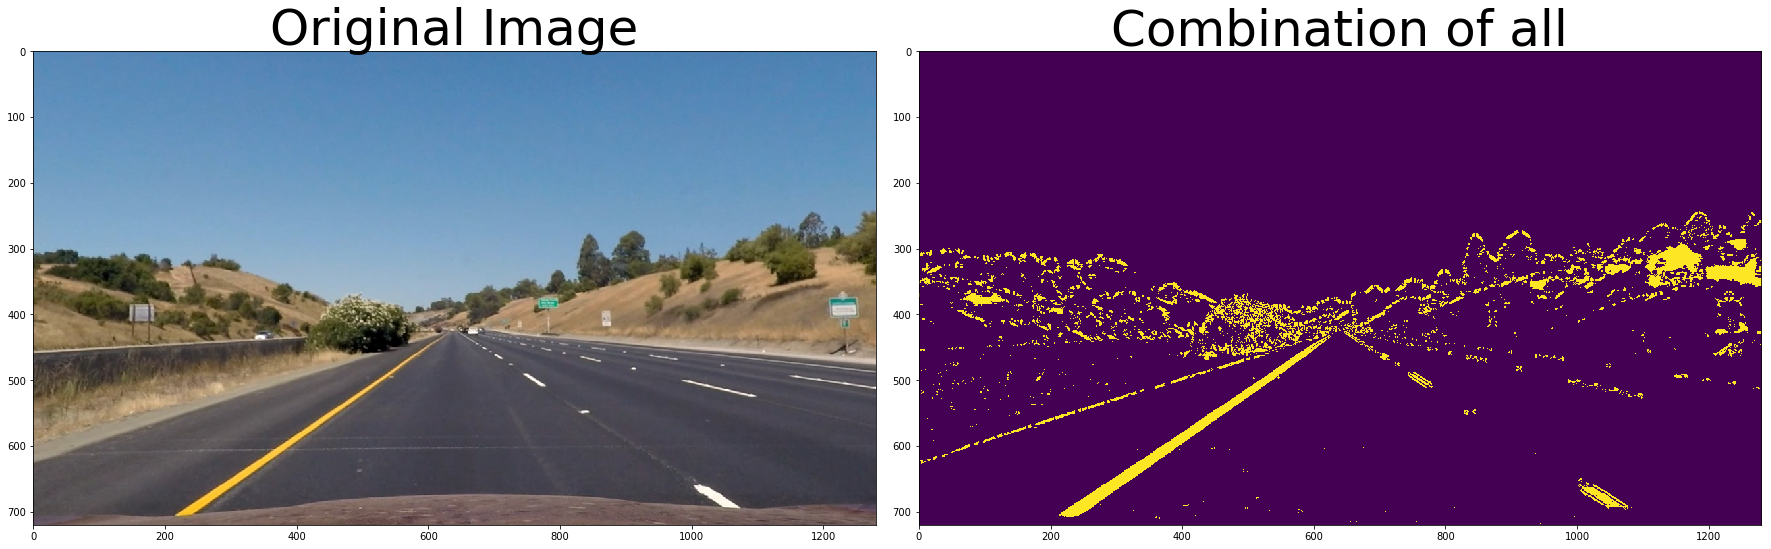

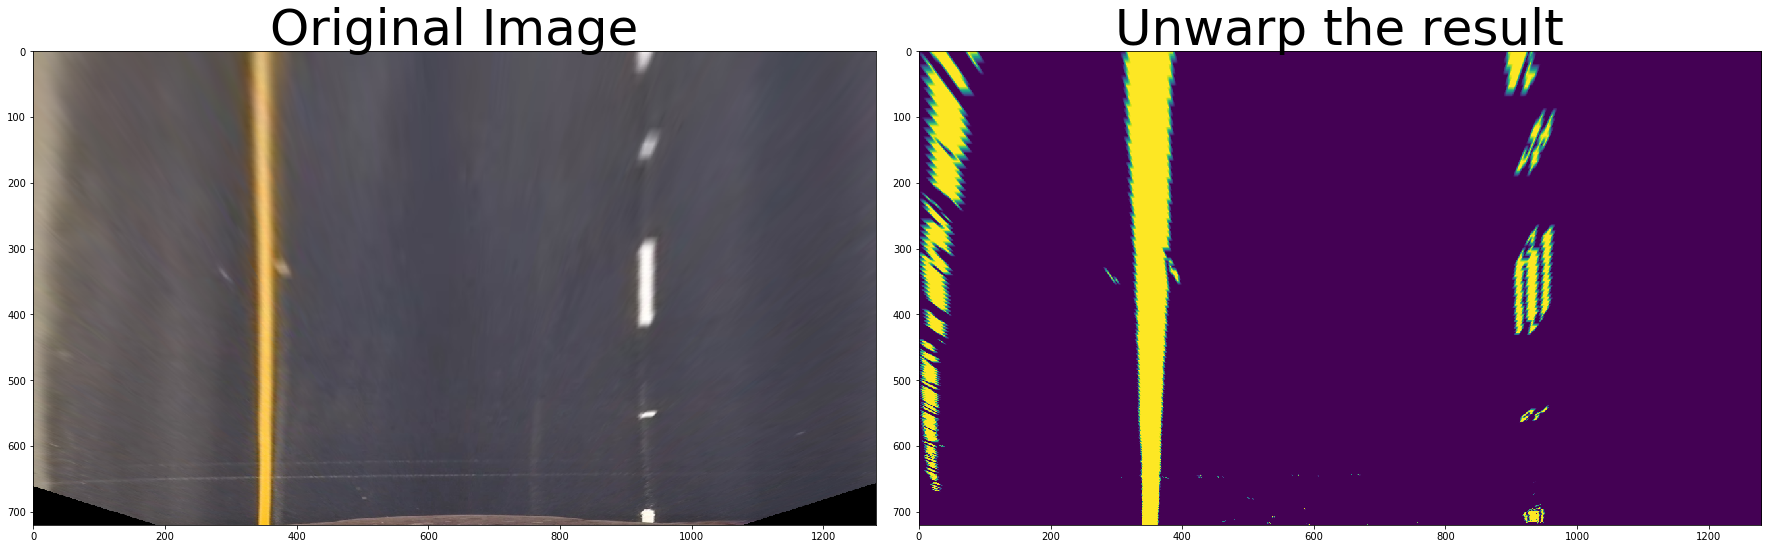

In [8]:
leftLane = Line()
rightLane = Line()
# Get the images   
combTestimg = cv2.imread('test_images/straight_lines1.jpg')
combTestimga = cv2.imread('test_images/test5.jpg')
#get the M and Minv matrices for warping
params = warpSettings(combTestimg)

M, Minv, img_size = params
# Full conversion
b = pipeline(combTestimg, params, debug = True)
a = pipeline(combTestimga, params, debug = False)

In [9]:
print(leftLane.allx)

None


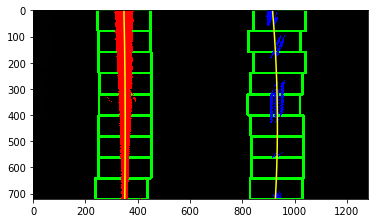

In [10]:
left_fit, right_fit, left_rad, right_rad, ploty = lineFinder(b, debug = True)
img = showResult(combTestimg, left_fit, right_fit, ploty, Minv)

In [11]:
left_rad

2529.8414562055932

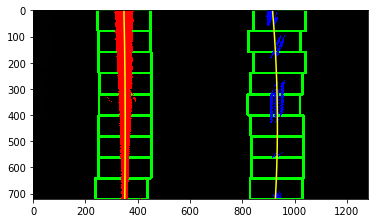

In [12]:
b=pipeline(combTestimg, params)
left_fit, right_fit, left_rad, right_rad, ploty = lineFinder(b, debug = True)
img = showResult(combTestimg, left_fit, right_fit, ploty, Minv)

# Test with videos
The following lines are for getting video files and converting them to images. The code then calls the pipeline for each image and applies the result on the videos

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    binary_warped = pipeline(image, params)
    #left_fit, right_fit, left_rad, right_rad, ploty = lineFinder(binary_warped)
    if(leftLane.detected == True or rightLane.detected == True):
        left_fit, right_fit, left_rad, right_rad, ploty = lineTracker(binary_warped, leftLane.current_fit, rightLane.current_fit)
    if(leftLane.detected == False or rightLane.detected == False):
        left_fit, right_fit, left_rad, right_rad, ploty = lineFinder(binary_warped)
        
    #average last three line polynomials here
    #dont update the parameters if the lane is weird
    result = showResult(image, left_fit, right_fit, ploty, Minv)
    return result

In [ ]:
white_output = 'output_images/project_result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(20,25)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video output_images/project_result.mp4
[MoviePy] Writing video output_images/project_result.mp4


 91%|████████████████████████████████████▌   | 115/126 [02:20<00:13,  1.21s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
fail1 = cv2.imread('test_images/test_fail1.jpg')
b=pipeline(fail1, params, debug = True)
left_fit, right_fit, left_rad, right_rad, ploty = lineFinder(b, debug = True)
fail2 = cv2.imread('test_images/test_fail2.jpg')
b=pipeline(fail1, params, debug = True)
left_fit, right_fit, left_rad, right_rad, ploty = lineFinder(b, debug = True)

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
hls = cv2.cvtColor(fail2, cv2.COLOR_BGR2HLS)
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
h_channel = hls[:,:,0]
s_channel = clahe.apply(s_channel)
s_binary = np.zeros_like(h_channel)
h_channel[(h_channel >= 19) & (h_channel <= 30)] = 1
plt.imshow(s_channel)

In [ ]:
left_fitx = np.mean(leftLane.recent_xfitted,0)
#any(isnan(left_fitx))
left_fitx is None

